<a href="https://colab.research.google.com/github/alkesnaf/musicrec/blob/main/alkesnaf_mrrubino_dasibbli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music Recommendation System
### Al-Kesna Foster, Matthew Rubino, Donovan Sibblies

## Imports

In [ ]:
import csv
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os import path
from google.colab import drive

In [ ]:
# Mount drive to grab files
drive.mount("/content/drive")

Mounted at /content/drive


## Constants

In [ ]:
BASE_PATH = "/content/drive/MyDrive/368 Final Project"

## Preprocessing



In [ ]:
# Load taste triplets into Pandas DataFrame
train_triplets_df = pd.read_csv(path.join(path.join(BASE_PATH, 'train_triplets.txt')), sep='\t', names=['user_id', 'song_id', 'listen_count'])
train_triplets_df

,user_id,song_id,listen_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1
...,...,...,...
48373581,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUHHHH12AF729E4AF,2
48373582,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUJVIT12A8C1451C1,1
48373583,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUSMXX12AB0185C24,1
48373584,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOWYSKH12AF72A303A,3


In [ ]:
# Filter songs at 90th percentile of listen count
song_counts = train_triplets_df.groupby('song_id').sum()
song_count_threshold = song_counts['listen_count'].quantile(.9)

filtered_songs = song_counts[song_counts['listen_count'] > song_count_threshold]
song_count_threshold

557.0

In [ ]:
# Filter users at 90th percentile of listen count
user_counts = train_triplets_df.groupby('user_id').sum()
user_count_threshold = user_counts['listen_count'].quantile(.9)

filtered_users = user_counts[user_counts['listen_count'] > user_count_threshold]
user_count_threshold

322.0

In [ ]:
# Generate ID maps
songIdMap = {songId: i for i,(songId,_) in enumerate(filtered_songs.itertuples())}
userIdMap = {userId: i for i,(userId,_) in enumerate(filtered_users.itertuples())}

In [ ]:
# Save ID maps to JSON
with open(path.join(BASE_PATH, 'song_id_map.json'), 'w') as f:
  json.dump(songIdMap, f)

with open(path.join(BASE_PATH, 'user_id_map.json'), 'w') as f:
  json.dump(userIdMap, f)

In [ ]:
# Load song list into Pandas DataFrame
song_list_df = pd.read_csv(path.join(BASE_PATH, 'song_list.txt'), sep='<SEP>', names=['track_id', 'song_id', 'artist', 'name'], engine='python')
song_list_df

,track_id,song_id,artist,name
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1,Hudson Mohawke,No One Could Ever
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C,Yerba Brava,Si Vos Querés
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF,Der Mystic,Tangle Of Aspens
...,...,...,...,...
999995,TRYYYUS12903CD2DF0,SOTXAME12AB018F136,Kiko Navarro,O Samba Da Vida
999996,TRYYYJO128F426DA37,SOXQYIQ12A8C137FBB,Kuldeep Manak,Jago Chhadeo
999997,TRYYYMG128F4260ECA,SOHODZI12A8C137BB3,Gabriel Le Mar,Novemba
999998,TRYYYDJ128F9310A21,SOLXGOR12A81C21EB7,Elude,Faraday


In [ ]:
# Filter and song list and taste list using song and user maps
with open(path.join(BASE_PATH, 'song_list.csv'), 'w') as f:
  writer = csv.writer(f)

  header = ['track_id', 'song_id', 'artist', 'name']
  writer.writerow(header)
  songNameMap ={}
  for _,trackId,songId,artist,name in song_list_df.itertuples():
    songNameMap[songId]= name
  for _,trackId,songId,artist,name in song_list_df.itertuples():
    if songId in songIdMap:
      row = [trackId, songIdMap[songId], artist, name]
      writer.writerow(row)

with open(path.join(BASE_PATH, 'train_triplets.csv'), 'w') as f:
  writer = csv.writer(f)

  header = ['user_id', 'song_id', 'listen_count']
  writer.writerow(header)

  for _,userId,songId,listenCount in train_triplets_df.itertuples():
    if userId in userIdMap and songId in songIdMap:
      row = [userIdMap[userId], songIdMap[songId], listenCount]
      writer.writerow(row)

KeyboardInterrupt: ignored

## Exploratory Analysis

In [ ]:
song_list_df = pd.read_csv(path.join(path.join(BASE_PATH, "song_list.csv")))
song_list_df.head()

,track_id,song_id,artist,name
0,TRMMMFG128F425087B,34175,Billy Idol,Scream
1,TRMMGCB128E079651D,11769,Morcheeba,Get Along (Feat: Pace Won) (Instrumental)
2,TRMMGTX128F92FB4D9,6392,Bacilos,Viejo
3,TRMMGDP128F933E59A,10735,Al Green,I Say A Little Prayer
4,TRMMHBF12903CF6E59,14295,Laurel & Hardy,At the Ball_ That's All


In [ ]:
train_triplets_df = pd.read_csv(path.join(path.join(BASE_PATH, "train_triplets.csv")))
train_triplets_df.head()

,user_id,song_id,listen_count
0,85198,215,12
1,85198,345,1
2,85198,851,1
3,85198,1467,1
4,85198,2402,7


In [ ]:
pd.set_option('float_format', '{:f}'.format)
train_triplets_df['listen_count'].describe()

count   11655110.000000
mean           4.029814
std           10.516052
min            1.000000
25%            1.000000
50%            1.000000
75%            4.000000
max         9667.000000
Name: listen_count, dtype: float64

In [ ]:
#grab song id of highest listen

train_triplets_df = train_triplets_df.sort_values(by='listen_count', ascending=False)
train_triplets_df.head()

,user_id,song_id,listen_count
7708956,3574,927,9667
4529330,76761,38048,3534
3149718,86205,2429,3532
11631176,9560,32114,2948
7299036,41821,32392,2381


In [ ]:
#Starshine by Gorillaz is the song with the highest listen count

In [ ]:
#join both datasets

merge_df = pd.merge(train_triplets_df, song_list_df, how = 'inner', on=['song_id'])
merge_df

,user_id,song_id,listen_count,track_id,artist,name
0,3574,927,9667,TRCSHLM128E078B891,Ry Cooder,Corrido de Boxeo
1,92138,927,143,TRCSHLM128E078B891,Ry Cooder,Corrido de Boxeo
2,74560,927,138,TRCSHLM128E078B891,Ry Cooder,Corrido de Boxeo
3,52390,927,133,TRCSHLM128E078B891,Ry Cooder,Corrido de Boxeo
4,21698,927,126,TRCSHLM128E078B891,Ry Cooder,Corrido de Boxeo
...,...,...,...,...,...,...
12038561,74907,26729,1,TRLMIIK128F934112A,Pretenders,Love's a Mystery (LP Version)
12038562,22856,26729,1,TRLMIIK128F934112A,Pretenders,Love's a Mystery (LP Version)
12038563,83385,26729,1,TRLMIIK128F934112A,Pretenders,Love's a Mystery (LP Version)
12038564,65902,26729,1,TRLMIIK128F934112A,Pretenders,Love's a Mystery (LP Version)


In [ ]:
#songs with the most listens (most popular songs)

merged_df = merge_df.groupby(['artist','track_id','name'])['listen_count'].sum().reset_index()
merged_df = merged_df.sort_values(by = 'listen_count', ascending = False)
merged_df.head()


,artist,track_id,name,listen_count
10559,Dwight Yoakam,TRAEHHJ12903CF492F,You're The One,248001
4309,Björk,TRGXQES128F42BA5EB,Undo,193745
19009,Kings Of Leon,TRONYHY128F92C9D11,Revelry,176102
3317,Barry Tuckwell/Academy of St Martin-in-the-Fie...,TRLGMFJ128F4217DBE,Horn Concerto No. 4 in E flat K495: II. Romanc...,126611
14786,Harmonia,TRDMBIJ128F4290431,Sehr kosmisch,126333


In [ ]:
#songs with the least listens

merged_df = merged_df.sort_values(by = 'listen_count', ascending = True)
merged_df.head()


,artist,track_id,name,listen_count
1083,Albertucho,TROXDPE128F4234ECD,Basura en la que nacen flores,30
36481,Tony Moran,TRRXLIN12903CB3DD7,Shine On,49
13306,Freaky Chakra,TRMRVJI128F148059D,Platform,52
13963,Glashaus,TRSTSSK128F92D382F,Dann bin das ich,54
27077,Queen,TRAWVBR128F930A60B,Las Palabras De Amor (The Words Of Love) (2009...,65


In [ ]:
#artist with the most listens

merged_df2 = merge_df.groupby(['artist'])['listen_count'].sum().reset_index()
merged_df2 = merged_df2.sort_values(by = 'listen_count', ascending = False)
merged_df2 = merged_df2.head()

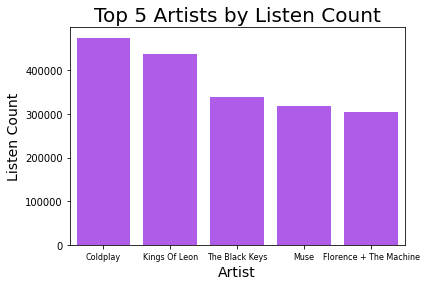

In [ ]:
sns.barplot(data=merged_df2, x='artist', y='listen_count', color ='#b445ff')
plt.xlabel('Artist', fontsize=14,);
plt.ylabel('Listen Count', fontsize=14);
plt.title('Top 5 Artists by Listen Count', fontsize=20)
plt.tick_params(axis='x', which='major', labelsize=8)



In [ ]:
#artists that appear the most(Most frquently listened to)

merged_df3 = merge_df.groupby(['artist']).size().reset_index()
merged_df3.columns = ['artist', 'count']
merged_df3.sort_values(by = 'count', ascending = False, inplace= True)
merged_df3

,artist,count
1979,Coldplay,140440
5131,Kings Of Leon,100617
8990,The Black Keys,96369
6530,Muse,89449
4278,Jack Johnson,81052
...,...,...
4579,Joby Talbot,6
9523,The Red Paintings,6
1283,Boo Reka,5
7814,Rolfe Kent,4


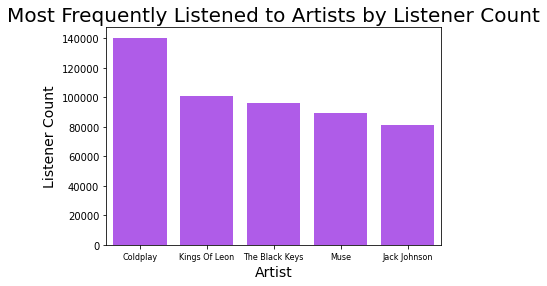

In [ ]:
#graph top 5 most frequently listened to artists listener count
top_artists = ['Coldplay','Kings Of Leon', 'The Black Keys', 'Muse', 'Jack Johnson']
temp_df1 = merged_df3[merged_df3['artist'].isin(top_artists)]
sns.barplot(data=temp_df1, x='artist', y='count', color ='#b445ff')
plt.xlabel('Artist', fontsize=14,);
plt.ylabel('Listener Count', fontsize=14);
plt.title('Most Frequently Listened to Artists by Listener Count', fontsize=20)
plt.tick_params(axis='x', which='major', labelsize=8)


In [ ]:
#artist with most songs
#not sure about this - may be counting duplicates of the same song(want unique songs)

merged_df4 = merge_df['artist'].value_counts()
merged_df4.head()

Coldplay          140440
Kings Of Leon     100617
The Black Keys     96369
Muse               89449
Jack Johnson       81052
Name: artist, dtype: int64

In [ ]:
#user with most listens (how many?)

merged_df5 = merge_df.groupby('user_id')['listen_count'].sum().reset_index()
merged_df5.columns = ['user_id', 'listen_count_sum']
merged_df5.sort_values(by = 'listen_count_sum', ascending = False, inplace = True)
merged_df5.head()

,user_id,listen_count_sum
3574,3574,12827
6841,6841,9175
25152,25153,8443
64479,64481,7094
15866,15866,5370


In [ ]:
#least popular song of most popular artist

top_artists = ['Kings Of Leon', 'Coldplay', 'The Black Keys', 'Muse', 'Florence + The Machine']
merged_df6 = merge_df.groupby(['artist', 'name'])['listen_count'].sum().reset_index()
merged_df6.sort_values(by = 'listen_count', ascending = False, inplace = True)
rslt_df = merged_df6[merged_df6['artist'].isin(top_artists)]
rslt_df = rslt_df.groupby('artist').min()
rslt_df.head()

,name,listen_count
artist,,
Coldplay,1.36,170
Florence + The Machine,Are You Hurting The One You Love?,945
Kings Of Leon,Arizona,357
Muse,Agitated [Live From Le Zenith],220
The Black Keys,10 A.M. Automatic,488


In [ ]:
#songs with most unique listeners
#not sure abt this

merge_df['user_id'].nunique()
merged_df7 = merge_df.groupby(['artist','name', 'user_id'])['listen_count'].sum().reset_index().groupby(['name', 'artist']).size().reset_index()
merged_df7.columns = ['artist','name', 'unique_listener_count']
merged_df7.sort_values(by = 'unique_listener_count', ascending = False, inplace= True)
merged_df7.head()

,artist,name,unique_listener_count
27322,Sehr kosmisch,Harmonia,18949
8044,Dog Days Are Over (Radio Edit),Florence + The Machine,17930
27266,Secrets,OneRepublic,15394
26015,Revelry,Kings Of Leon,15214
34884,Undo,Björk,14916


## Loading Data

In [ ]:
# Load maps from JSON
with open(path.join(BASE_PATH, "song_id_map.json")) as f:
  songIdMap = json.load(f)

with open(path.join(BASE_PATH, "user_id_map.json")) as f:
  userIdMap = json.load(f)

In [ ]:
m, n = len(userIdMap), len(songIdMap)

In [ ]:
# Load listen counts
ratings = np.zeros((m,n), dtype=np.uint8)

with open(path.join(BASE_PATH, "train_triplets.csv")) as f:
  reader = csv.reader(f)
  next(reader)

  for userId, songId, listenCount in reader:
    userId, songId, listenCount = int(userId), int(songId), int(listenCount)

    # Clamp listen count to 255 b/c that is maximum 8-bit value
    listenCount = min(listenCount, 255)
    ratings[userId][songId] = listenCount

## Similarity Functions

In [ ]:
def cosine_similarity(a, b):
  magA = np.linalg.norm(a)
  magB = np.linalg.norm(b)

  if magA == 0 or magB == 0:
    return 0
  else:
    return a.dot(b) / (magA * magB)

In [ ]:
def euclidean_similarity(a, b):
  return 1 / (1 + np.linalg.norm(a - b))

In [ ]:
def centered_cosine_similarity(a, b):
  aBar = np.mean(a)
  bBar = np.mean(b)

  return cosine_similarity(a-aBar, b-bBar)

## Collaborative Filtering

In [ ]:
# User-based
def collaborative_filtering(data, userRatings, similarityFunction=euclidean_similarity, N=100):
  userCount, songCount = len(data), len(data[0])

  assert N <= userCount, 'the value of "N" cannot exceed the number of users'

  userSongIds = [songId for songId,listenCount in userRatings]
  userListenCounts = [listenCount for songId,listenCount in userRatings]

  filteredData = data[:,userSongIds]

  similarities = np.array([
    similarityFunction(filteredData[userId], userListenCounts) \
    for userId in range(userCount)
  ])

  mostSimilarUsers = np.argsort(similarities)[-N:]
  mostSimilarRatings = data[mostSimilarUsers]
  mostSimilarSimilarities = similarities[mostSimilarUsers]

  similaritySum = np.sum(mostSimilarSimilarities)

  newRatings = mostSimilarSimilarities.dot(mostSimilarRatings) / similaritySum
  return newRatings

## Results

In [ ]:
# Create test user who listens to rap music
# 29107 = RoboCop - Kanye West
# 18766 = Evil Deeds - Eminem
# 24856 = Family Business - Kanye West
# 7517 = Got Money - Lil Wayne / T-Pain
# 3852 = Coldest Winter - Kanye West

# User ratings is a "song id"-"listen count" tuple
# For this example, the example user has listened to each song ten times
userRatings = [(29107, 10), (18766, 10), (24856, 10), (7517, 10), (3852, 10)]

In [ ]:
predictedUserRatings = collaborative_filtering(ratings, userRatings, euclidean_similarity)

In [ ]:
bestPredictedSongs = np.argsort(predictedUserRatings)[-5:]

In [ ]:
bestPredictedSongs

array([14655, 36216, 29107,  3852, 30846])

In [ ]:
# 14655 = Street Lights - Kanye West
# 36216 = Say You Will - Kanye West
# 29107 = RoboCop - Kanye West
# 3852 = Coldest Winter - Kanye West
# 30846 = Gears - Future Rock

In [ ]:
# Al-kesna
# 22176 = Flashing Lights - Kanye West
# 14655 = Street Lights - Kanye West
# 23869 = Pursuit of Happiness - Kid Cudi
# 29461 = Champion - Buju Banton
# 25912 = If I Ain't Got You

userRatings = [(22176,10),(14655,10),(23869,10),(29461,10),(25912,10)]



In [ ]:
predictedUserRatings = collaborative_filtering(ratings, userRatings, euclidean_similarity)

In [ ]:
bestPredictedSongs = np.argsort(predictedUserRatings)[-5:]

In [ ]:
bestPredictedSongs

array([ 2429, 21863,  4821, 21429, 23869])

In [ ]:
#Marc
userRatings = [(14807,10),(14092,10),(19686,10),(16868,10),(24856,10)]
predictedUserRatings = collaborative_filtering(ratings, userRatings, euclidean_similarity)
bestPredictedSongs = np.argsort(predictedUserRatings)[-6:]
bestPredictedSongs

array([30291, 14807, 24856, 28596, 19210,  1275])

In [ ]:
#Grace
userRatings = [(22835,10),(14102,10),(34312,10),(24088,10),(25351,10)]
predictedUserRatings = collaborative_filtering(ratings, userRatings, euclidean_similarity)
bestPredictedSongs = np.argsort(predictedUserRatings)[-8:]
bestPredictedSongs

array([ 8855, 21429,  2443, 24047,  1275,  2429, 25351, 24088])

## References

- http://millionsongdataset.com/tasteprofile
- http://millionsongdataset.com/sites/default/files/AdditionalFiles/unique_tracks.txt
- https://towardsdatascience.com/intro-to-recommender-system-collaborative-filtering-64a238194a26
- https://realpython.com/build-recommendation-engine-collaborative-filtering